In [1]:
!pip install monai pydicom gdcm pylibjpeg pylibjpeg-libjpeg
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.9 MB/s eta 0:00:00


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-03-29 07:48:46.572255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:48:46.572365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:48:46.693852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-03-29 07:49:28.709147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:49:28.709214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:49:28.710625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [4]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle


from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [5]:
# diseases = ['Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
diseases = ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia', 'image_id']


In [6]:
## From past experiments ##
corrupted_ids = [
    '99905540dca6c8ece8e07ace8362b679',
    'd22b70c6029843ebff15c7e0d0c4b259',
]

In [7]:
# some helper functions:-
def delete_corrupted(df, corrupted_ids):
    df = df[~df['image_id'].isin(corrupted_ids)]
    return df

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
#     print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def change_dtype(df, To, columns=diseases, root_folder='/train'):
    # Convert data types of specified columns
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(To)
            except ValueError:
                print(f"Unable to convert column '{col}' to data type '{To}'")
    print(f"Changed datatypes of columns of {root_folder.split('/')[-1]} folder")
    return df
    
def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df
    
    
def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy"))
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df

In [8]:
# Loading the original csv files
train_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_train.csv')
test_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_test.csv')

# delete corrupted images
train_data = delete_corrupted(train_data, corrupted_ids)


disease_labels = list(train_data.columns)[2:]
print("ORIGINAL disease labels:", disease_labels)

# Count occurrences of each class
class_counts = train_data.iloc[:, 2:].sum()
print("TOTAL train Individual class counts:-\n", class_counts)
print('-'*100)

class_counts = test_data.iloc[:, 2:].sum()
print("TOTAL test Individual class counts:-\n", class_counts)
print('-'*100)


train_data = change_dtype(train_data, To='int', columns=diseases, root_folder='train')
train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/train')
print('-'*100)

test_data = change_dtype(test_data, To='int', columns=diseases, root_folder='test')
test_data = delete_columns(test_data, columns_to_keep=columns_to_keep, root_folder='test')
test_data = remove_all_zeros(test_data, diseases=diseases, root_folder='test')
test_data = add_file_path_column(test_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/test')
print('-'*100)

# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# reducing the size (comment this)
# train_data = train_data.head(100)
# val_data = val_data.head(100)
# test_data = test_data.head(100)



# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)


# collecting & storing the labels separately
train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values

print(f"test_paths:", test_paths[:2])
print(f"test_labels:", test_labels[:10])



print("length of train:", len(train_data))
print("length of val:", len(val_data))
print("length of test:", len(test_data))

ORIGINAL disease labels: ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']
TOTAL train Individual class counts:-
 No finding                  5141.0
Bronchitis                   842.0
Brocho-pneumonia             545.0
Other disease                412.0
Bronchiolitis                497.0
Situs inversus                11.0
Pneumonia                    392.0
Pleuro-pneumonia               6.0
Diagphramatic hernia           3.0
Tuberculosis                  14.0
Congenital emphysema           2.0
CPAM                           5.0
Hyaline membrane disease      19.0
Mediastinal tumor              8.0
Lung tumor                     5.0
dtype: float64
----------------------------------------------------------------------------------------------------
TOTAL test Individual clas

In [9]:
train_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,c76d79791581a94129a5545aaf818406,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,d4a9ad56da743e2e1cf56739740972a0,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,6bfac722cab40ad0c2b863655178def7,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,0b032af6f463641a35c43aeb901165c5,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,30d36ee4926e2fb0c265b013b7d7155c,0,1,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [10]:
val_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,5b154b6f97bfb4357db1aa909af6fd0e,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,47938716d348b0b3778a5dd2f877df72,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,0b431b93353fd7c21f4f0a202d41fb1a,0,0,0,1,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,83f6f2191eced92b25b2d571f2c76153,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,37efd124615e7890d7e1771ab3177d32,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [11]:
test_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,d7e71a052a753c3f2f3e317d60177bec,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,e64d9421e78c82b5c104021a6c1b4e67,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,8a12a4352a866aaea4691dd27a99c7ae,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,30d6a0843a9792168fdc456c17a9028c,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,f22138be08a24e79cf07f6207341e5f5,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [12]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



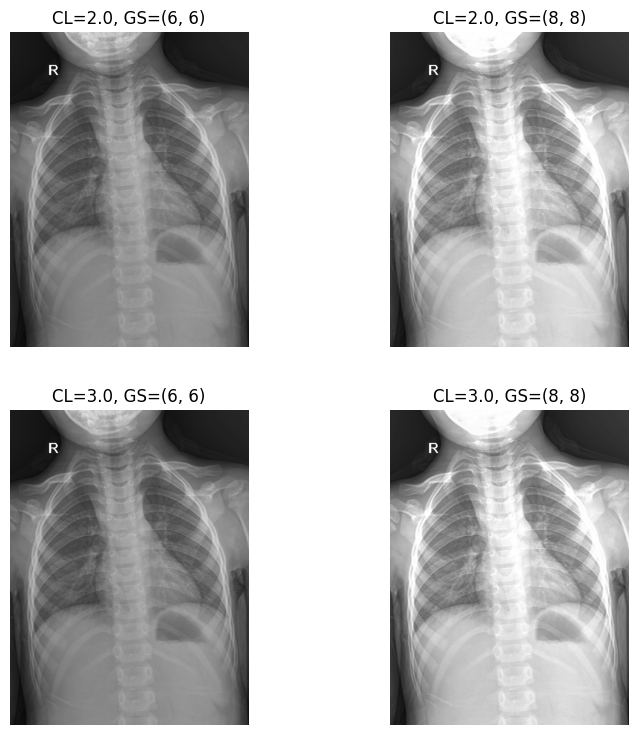

In [13]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/000295d6ff55184f19d99e95f93c3a55.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/002cf1f4cba98648335843f21756ee36.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/0119beca31970c7d5293316a515d7ee9.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/01b9c6193cfd9c247cad1b843a95aca7.dicom'
path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/021405230e5a837a061b9c87f9d2565b.dicom'

clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []

for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

In [14]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files)) 

6878
765
1386


image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


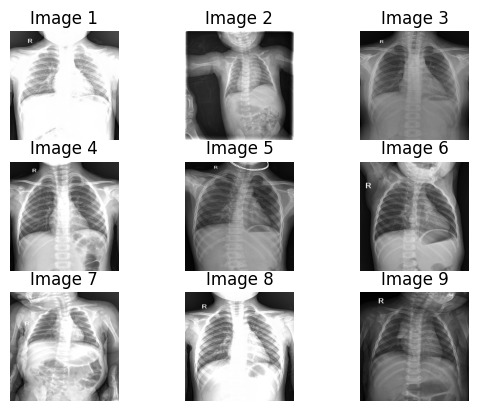

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):
#     dicom_image = pydicom.dcmread(train_image_files[k])
    
    # Typecast to float64
#     float64_image_array = dicom_image.pixel_array.astype(np.float64)
    
    float64_image_array = np.load(train_image_files[k])
    print("image_shape:", float64_image_array.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [16]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
num_classes = len(diseases) 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes:", num_classes)

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes: 6


In [17]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), # highly sensitive data
#         RandFlip(spatial_axis=0, prob=0.5),  # some abnormalities may be localized in a particular side
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [18]:
class VINDR_PCXR_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         labels = torch.tensor(labels.values, dtype=torch.long)  # Use dtype=torch.long
        
#         dicom = pydicom.read_file(img_path)
#         image = dicom.pixel_array.astype(np.float32)
#         image = read_xray(img_path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(6,6))
        
        image = np.load(img_path)
    
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, labels


train_ds = VINDR_PCXR_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_PCXR_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_PCXR_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 860
No. of VAL batches: 96
No. of TEST batches: 174


In [19]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model


class SwinTransformerModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(SwinTransformerModel, self).__init__()
        self.swin = create_model(
            'swin_large_patch4_window7_224.ms_in22k', 
            pretrained=True,
            num_classes=num_classes,
            in_chans=1
        )
        
        if not fine_tune:
            for param in self.swin.parameters():
                param.requires_grad = False
            
            for param in self.swin.head.parameters():
                param.requires_grad = True
        

    def forward(self, x):
        x = self.swin(x)
        return x
    
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits 
display_params_flops(model)

model.safetensors:   0%|          | 0.00/916M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 6])
tensor([[-0.1523,  0.4273,  0.0574,  0.6546,  0.4203,  0.5721]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 195.00 M
Number of trainable parameters in millions: 0.01 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 34.06G, Params: 194.90M


In [21]:
model = SwinTransformerModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-5) # adjust learning rate 
# reduce lr during fine tuning

In [22]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, 2, (3, num_classes))  # Example targets (binary, one-hot encoded)
print(logits)
print(targets)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Calculate the loss
loss = criterion(logits, targets.float())
print("loss:", loss)

tensor([[ 0.4981,  0.3878,  1.1307,  0.3122, -0.2465,  0.5845],
        [-0.4160,  0.6678, -2.0650,  1.3129, -1.6573,  1.4430],
        [-1.1441,  0.9043, -0.0773,  0.3707,  0.5092,  0.3533]])
tensor([[1, 0, 1, 0, 1, 1],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])
loss: tensor(0.7303)


In [23]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch, total_time_elapsed
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
            
            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("train_batch_outputs:", outputs)
#             print("train_batch_labels:", labels)
            
            outputs = outputs.float()
            labels = labels.float()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.sigmoid(outputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0) * labels.size(1)
            
            correct_train += (predictions == labels).sum().item()
            
#             print("train_batch_predictions:", predictions)
#             print("train_batch_scores:", scores)
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
#             train_labels_all.extend(labels)
#             train_predictions_all.extend(predictions)
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print(classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = multilabel_confusion_matrix(train_predictions_all, train_labels_all)
        # we will use macro-averaging strategy.
        accuracy_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        
        for i in range(num_classes):
#             print(cm[i])
#             print(cm[i].sum())
            
#             cfm_plot = sn.heatmap(cm[i], annot=False)
             # TP + TN / TP + TN  + FP + FN
            accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

            # TP / TP + FP
            precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

            # TP / TP + FN
            recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
            f1 = (2*precision*recall)/(precision+recall)
#             print(diseases[i],": ",round(accuracy*100,2),"%")
#             print("Precision: ",round(precision,2))
#             print("Recall:", round(recall,2))
#             print("F1-Score:", round(f1,2))
#             print('==========================================================')


            accuracy_arr.append(accuracy)
            precision_arr.append(precision)
            recall_arr.append(recall)
            f1_arr.append(f1)
        
        
        accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
        accuracy_macro_train = round(sum(accuracy_arr) / len(accuracy_arr), 4)
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        roc_auc_macro_train = round(roc_auc_score(train_labels_all, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.float()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.sigmoid(outputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0) * labels.size(1)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

    #         print(classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = multilabel_confusion_matrix(val_predictions_all, val_labels_all)
            # we will use macro-averaging strategy.
            accuracy_arr = []
            precision_arr = []
            recall_arr = []
            f1_arr = []

            for i in range(num_classes):
    #             print(cm[i])
    #             print(cm[i].sum())

    #             cfm_plot = sn.heatmap(cm[i], annot=False)
#                 TP + TN / TP + TN  + FP + FN
                accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

                # TP / TP + FP
                precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

                # TP / TP + FN
                recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
                f1 = (2*precision*recall)/(precision+recall)
    #             print(diseases[i],": ",round(accuracy*100,2),"%")
    #             print("Precision: ",round(precision,2))
    #             print("Recall:", round(recall,2))
    #             print("F1-Score:", round(f1,2))
    #             print('==========================================================')

        
                accuracy_arr.append(accuracy)
                precision_arr.append(precision)
                recall_arr.append(recall)
                f1_arr.append(f1)
            
            accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)
            
            accuracy_macro_val = round(sum(accuracy_arr) / len(accuracy_arr), 4)
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)
            roc_auc_macro_val = round(roc_auc_score(val_labels_all, val_scores_all, average='macro'), 4)
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [24]:
 history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=30,
          ranOnce=False,
         save_interval=10)

Starting afresh!


100%|██████████| 860/860 [01:44<00:00,  8.22it/s]


Current epoch 1/30
Training Loss: 0.3815, Accuracy: 0.8632
correct: 35623  out of  41268
MACRO-averged metrics:- accuracy: 0.8632, precision: 0.1593, recall: 0.1854, f1: 0.1628, ROC_AUC: 0.5138


100%|██████████| 96/96 [00:11<00:00,  8.25it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3183, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.504
Time_for_this_epoch: 116.3669 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 2/30
Training Loss: 0.3140, Accuracy: 0.8869
correct: 36599  out of  41268
MACRO-averged metrics:- accuracy: 0.8869, precision: 0.1121, recall: 0.1667, f1: 0.134, ROC_AUC: 0.5332


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3164, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.5268
Time_for_this_epoch: 115.0918 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 3/30
Training Loss: 0.3123, Accuracy: 0.8868
correct: 36598  out of  41268
MACRO-averged metrics:- accuracy: 0.8868, precision: 0.1121, recall: 0.1667, f1: 0.134, ROC_AUC: 0.5586


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3153, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.5523
Time_for_this_epoch: 115.1220 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 4/30
Training Loss: 0.3112, Accuracy: 0.8869
correct: 36600  out of  41268
MACRO-averged metrics:- accuracy: 0.8869, precision: 0.1121, recall: 0.1667, f1: 0.134, ROC_AUC: 0.5699


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3138, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.5716
Time_for_this_epoch: 115.2260 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 5/30
Training Loss: 0.3098, Accuracy: 0.8869
correct: 36601  out of  41268
MACRO-averged metrics:- accuracy: 0.8869, precision: 0.1121, recall: 0.1667, f1: 0.1341, ROC_AUC: 0.5898


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3129, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.5884
Time_for_this_epoch: 114.9595 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 6/30
Training Loss: 0.3091, Accuracy: 0.8870
correct: 36603  out of  41268
MACRO-averged metrics:- accuracy: 0.887, precision: 0.1122, recall: 0.1667, f1: 0.1341, ROC_AUC: 0.5995


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3123, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.6008
Time_for_this_epoch: 114.8457 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 7/30
Training Loss: 0.3083, Accuracy: 0.8870
correct: 36605  out of  41268
MACRO-averged metrics:- accuracy: 0.887, precision: 0.1122, recall: 0.1666, f1: 0.1341, ROC_AUC: 0.6055


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3118, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.6087
Time_for_this_epoch: 114.9571 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 8/30
Training Loss: 0.3075, Accuracy: 0.8871
correct: 36609  out of  41268
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.1123, recall: 0.1665, f1: 0.1341, ROC_AUC: 0.6116


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3109, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.6135
Time_for_this_epoch: 115.0662 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 9/30
Training Loss: 0.3068, Accuracy: 0.8872
correct: 36615  out of  41268
MACRO-averged metrics:- accuracy: 0.8872, precision: 0.1124, recall: 0.1665, f1: 0.1342, ROC_AUC: 0.6174


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3105, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.1124, recall: 0.1667, f1: 0.1343, ROC_AUC: 0.6143
Time_for_this_epoch: 115.0963 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 10/30
Training Loss: 0.3065, Accuracy: 0.8875
correct: 36624  out of  41268
MACRO-averged metrics:- accuracy: 0.8875, precision: 0.1126, recall: 0.1664, f1: 0.1343, ROC_AUC: 0.6186


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3100, Accuracy: 0.8878
correct: 4075  out of  4590
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.1133, recall: 0.166, f1: 0.1347, ROC_AUC: 0.6213
Time_for_this_epoch: 114.9138 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 10


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 11/30
Training Loss: 0.3059, Accuracy: 0.8877
correct: 36633  out of  41268
MACRO-averged metrics:- accuracy: 0.8877, precision: 0.1128, recall: 0.1661, f1: 0.1343, ROC_AUC: 0.6229


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3101, Accuracy: 0.8880
correct: 4076  out of  4590
MACRO-averged metrics:- accuracy: 0.888, precision: 0.1135, recall: 0.166, f1: 0.1348, ROC_AUC: 0.6234
Time_for_this_epoch: 115.1074 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:44<00:00,  8.26it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 12/30
Training Loss: 0.3056, Accuracy: 0.8877
correct: 36633  out of  41268
MACRO-averged metrics:- accuracy: 0.8877, precision: 0.1129, recall: 0.1657, f1: 0.1343, ROC_AUC: 0.627


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3097, Accuracy: 0.8880
correct: 4076  out of  4590
MACRO-averged metrics:- accuracy: 0.888, precision: 0.1135, recall: 0.1657, f1: 0.1348, ROC_AUC: 0.625
Time_for_this_epoch: 115.7901 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 13/30
Training Loss: 0.3047, Accuracy: 0.8878
correct: 36638  out of  41268
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.1129, recall: 0.1659, f1: 0.1344, ROC_AUC: 0.6324


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3095, Accuracy: 0.8885
correct: 4078  out of  4590
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.1142, recall: 0.1644, f1: 0.1348, ROC_AUC: 0.6251
Time_for_this_epoch: 115.2466 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 14/30
Training Loss: 0.3045, Accuracy: 0.8883
correct: 36657  out of  41268
MACRO-averged metrics:- accuracy: 0.8883, precision: 0.1133, recall: 0.1657, f1: 0.1346, ROC_AUC: 0.6302


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3089, Accuracy: 0.8882
correct: 4077  out of  4590
MACRO-averged metrics:- accuracy: 0.8882, precision: 0.1139, recall: 0.1651, f1: 0.1348, ROC_AUC: 0.6261
Time_for_this_epoch: 115.1387 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 15/30
Training Loss: 0.3036, Accuracy: 0.8883
correct: 36659  out of  41268
MACRO-averged metrics:- accuracy: 0.8883, precision: 0.2801, recall: 0.1657, f1: 0.1355, ROC_AUC: 0.6403


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3089, Accuracy: 0.8885
correct: 4078  out of  4590
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.114, recall: 0.1651, f1: 0.1349, ROC_AUC: 0.6293
Time_for_this_epoch: 115.2750 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 16/30
Training Loss: 0.3037, Accuracy: 0.8885
correct: 36667  out of  41268
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.2802, recall: 0.1657, f1: 0.1355, ROC_AUC: 0.6375


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3084, Accuracy: 0.8882
correct: 4077  out of  4590
MACRO-averged metrics:- accuracy: 0.8882, precision: 0.1139, recall: 0.1651, f1: 0.1348, ROC_AUC: 0.6298
Time_for_this_epoch: 114.9167 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 17/30
Training Loss: 0.3031, Accuracy: 0.8885
correct: 36666  out of  41268
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.2802, recall: 0.1656, f1: 0.1355, ROC_AUC: 0.6421


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3083, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.1145, recall: 0.1638, f1: 0.1348, ROC_AUC: 0.63
Time_for_this_epoch: 115.2332 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 18/30
Training Loss: 0.3032, Accuracy: 0.8890
correct: 36687  out of  41268
MACRO-averged metrics:- accuracy: 0.889, precision: 0.2806, recall: 0.1654, f1: 0.1357, ROC_AUC: 0.6428


100%|██████████| 96/96 [00:11<00:00,  8.37it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3081, Accuracy: 0.8885
correct: 4078  out of  4590
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.1143, recall: 0.1638, f1: 0.1347, ROC_AUC: 0.6329
Time_for_this_epoch: 114.9238 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 19/30
Training Loss: 0.3026, Accuracy: 0.8893
correct: 36701  out of  41268
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.2809, recall: 0.1651, f1: 0.1359, ROC_AUC: 0.6432


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3075, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.1145, recall: 0.1638, f1: 0.1348, ROC_AUC: 0.6331
Time_for_this_epoch: 114.8418 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 20/30
Training Loss: 0.3025, Accuracy: 0.8895
correct: 36706  out of  41268
MACRO-averged metrics:- accuracy: 0.8895, precision: 0.281, recall: 0.1651, f1: 0.1359, ROC_AUC: 0.645


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3078, Accuracy: 0.8889
correct: 4080  out of  4590
MACRO-averged metrics:- accuracy: 0.8889, precision: 0.1144, recall: 0.1647, f1: 0.135, ROC_AUC: 0.6344
Time_for_this_epoch: 114.8874 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 20


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 21/30
Training Loss: 0.3022, Accuracy: 0.8893
correct: 36701  out of  41268
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.1976, recall: 0.1652, f1: 0.1359, ROC_AUC: 0.6462


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3075, Accuracy: 0.8889
correct: 4080  out of  4590
MACRO-averged metrics:- accuracy: 0.8889, precision: 0.1144, recall: 0.1647, f1: 0.135, ROC_AUC: 0.6344
Time_for_this_epoch: 115.1148 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 22/30
Training Loss: 0.3018, Accuracy: 0.8897
correct: 36715  out of  41268
MACRO-averged metrics:- accuracy: 0.8897, precision: 0.1979, recall: 0.1656, f1: 0.137, ROC_AUC: 0.6517


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3069, Accuracy: 0.8889
correct: 4080  out of  4590
MACRO-averged metrics:- accuracy: 0.8889, precision: 0.1146, recall: 0.1641, f1: 0.1349, ROC_AUC: 0.6337
Time_for_this_epoch: 114.9679 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 23/30
Training Loss: 0.3016, Accuracy: 0.8893
correct: 36700  out of  41268
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.2254, recall: 0.1654, f1: 0.1368, ROC_AUC: 0.6523


100%|██████████| 96/96 [00:11<00:00,  8.36it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3073, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.1144, recall: 0.1641, f1: 0.1348, ROC_AUC: 0.6368
Time_for_this_epoch: 114.9823 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 24/30
Training Loss: 0.3012, Accuracy: 0.8898
correct: 36719  out of  41268
MACRO-averged metrics:- accuracy: 0.8898, precision: 0.2257, recall: 0.1654, f1: 0.137, ROC_AUC: 0.6533


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3072, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.1143, recall: 0.1644, f1: 0.1349, ROC_AUC: 0.6368
Time_for_this_epoch: 115.1648 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 25/30
Training Loss: 0.3008, Accuracy: 0.8898
correct: 36721  out of  41268
MACRO-averged metrics:- accuracy: 0.8898, precision: 0.2258, recall: 0.1652, f1: 0.137, ROC_AUC: 0.6546


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3066, Accuracy: 0.8891
correct: 4081  out of  4590
MACRO-averged metrics:- accuracy: 0.8891, precision: 0.1148, recall: 0.1638, f1: 0.135, ROC_AUC: 0.6374
Time_for_this_epoch: 114.9467 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 26/30
Training Loss: 0.3009, Accuracy: 0.8898
correct: 36721  out of  41268
MACRO-averged metrics:- accuracy: 0.8898, precision: 0.1981, recall: 0.165, f1: 0.1369, ROC_AUC: 0.6528


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3065, Accuracy: 0.8891
correct: 4081  out of  4590
MACRO-averged metrics:- accuracy: 0.8891, precision: 0.1147, recall: 0.1641, f1: 0.135, ROC_AUC: 0.639
Time_for_this_epoch: 114.9651 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 27/30
Training Loss: 0.3006, Accuracy: 0.8893
correct: 36699  out of  41268
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.1978, recall: 0.1652, f1: 0.1376, ROC_AUC: 0.6567


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3065, Accuracy: 0.8885
correct: 4078  out of  4590
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.1148, recall: 0.1621, f1: 0.1344, ROC_AUC: 0.639
Time_for_this_epoch: 115.1136 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 28/30
Training Loss: 0.2998, Accuracy: 0.8902
correct: 36736  out of  41268
MACRO-averged metrics:- accuracy: 0.8902, precision: 0.2151, recall: 0.1654, f1: 0.138, ROC_AUC: 0.6617


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3063, Accuracy: 0.8893
correct: 4082  out of  4590
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.115, recall: 0.1638, f1: 0.1351, ROC_AUC: 0.6406
Time_for_this_epoch: 114.8559 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.32it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 29/30
Training Loss: 0.3001, Accuracy: 0.8900
correct: 36729  out of  41268
MACRO-averged metrics:- accuracy: 0.89, precision: 0.226, recall: 0.1652, f1: 0.1371, ROC_AUC: 0.6581


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3064, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.1151, recall: 0.1615, f1: 0.1344, ROC_AUC: 0.641
Time_for_this_epoch: 114.9614 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:43<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 30/30
Training Loss: 0.2995, Accuracy: 0.8902
correct: 36735  out of  41268
MACRO-averged metrics:- accuracy: 0.8902, precision: 0.2103, recall: 0.1659, f1: 0.1389, ROC_AUC: 0.663


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3062, Accuracy: 0.8889
correct: 4080  out of  4590
MACRO-averged metrics:- accuracy: 0.8889, precision: 0.1153, recall: 0.1612, f1: 0.1345, ROC_AUC: 0.64
Time_for_this_epoch: 114.8284 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 30


### Fine Tune ( replace model name )

In [25]:
model = SwinTransformerModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 7e-6) # adjust learning rate 
# reduce lr during fine tuning

In [26]:
# give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=70,
          ranOnce=True, model_path='/kaggle/working/model_30.pth', history_path='/kaggle/working/history.csv',
         epochs_ran=30, save_interval=10)

Model was already trained fo 30 epochs,    with minimum loss: 0.306216727476567, max accuracy: 0.8893,    max auc: 0.641, max precision: 0.1153,     max recall: 0.1667, max f1: 0.1351


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 31/100
Training Loss: 0.2949, Accuracy: 0.8920
correct: 36809  out of  41268
MACRO-averged metrics:- accuracy: 0.892, precision: 0.4053, recall: 0.1613, f1: 0.1491, ROC_AUC: 0.6732


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3001, Accuracy: 0.8885
correct: 4078  out of  4590
MACRO-averged metrics:- accuracy: 0.8885, precision: 0.2729, recall: 0.141, f1: 0.1492, ROC_AUC: 0.6891
Time_for_this_epoch: 321.3431 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 32/100
Training Loss: 0.2793, Accuracy: 0.8971
correct: 37022  out of  41268
MACRO-averged metrics:- accuracy: 0.8971, precision: 0.5171, recall: 0.1654, f1: 0.1688, ROC_AUC: 0.7325


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.2919, Accuracy: 0.8946
correct: 4106  out of  4590
MACRO-averged metrics:- accuracy: 0.8946, precision: 0.4354, recall: 0.1453, f1: 0.1498, ROC_AUC: 0.7012
Time_for_this_epoch: 320.7121 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 33/100
Training Loss: 0.2660, Accuracy: 0.9010
correct: 37182  out of  41268
MACRO-averged metrics:- accuracy: 0.901, precision: 0.6038, recall: 0.1753, f1: 0.1898, ROC_AUC: 0.7713


100%|██████████| 96/96 [00:11<00:00,  8.22it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.2940, Accuracy: 0.8922
correct: 4095  out of  4590
MACRO-averged metrics:- accuracy: 0.8922, precision: 0.2772, recall: 0.1455, f1: 0.1564, ROC_AUC: 0.7151
Time_for_this_epoch: 320.9594 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 34/100
Training Loss: 0.2473, Accuracy: 0.9062
correct: 37399  out of  41268
MACRO-averged metrics:- accuracy: 0.9062, precision: 0.6097, recall: 0.1982, f1: 0.2302, ROC_AUC: 0.8153


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.2962, Accuracy: 0.8922
correct: 4095  out of  4590
MACRO-averged metrics:- accuracy: 0.8922, precision: 0.4399, recall: 0.1659, f1: 0.1899, ROC_AUC: 0.7215
Time_for_this_epoch: 321.7483 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 35/100
Training Loss: 0.2224, Accuracy: 0.9151
correct: 37764  out of  41268
MACRO-averged metrics:- accuracy: 0.9151, precision: 0.7089, recall: 0.238, f1: 0.291, ROC_AUC: 0.8602


100%|██████████| 96/96 [00:11<00:00,  8.28it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3150, Accuracy: 0.8902
correct: 4086  out of  4590
MACRO-averged metrics:- accuracy: 0.8902, precision: 0.2674, recall: 0.165, f1: 0.1706, ROC_AUC: 0.7075
Time_for_this_epoch: 320.6493 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 36/100
Training Loss: 0.1919, Accuracy: 0.9264
correct: 38229  out of  41268
MACRO-averged metrics:- accuracy: 0.9264, precision: 0.7308, recall: 0.303, f1: 0.3844, ROC_AUC: 0.902


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3361, Accuracy: 0.8922
correct: 4095  out of  4590
MACRO-averged metrics:- accuracy: 0.8922, precision: 0.3266, recall: 0.1682, f1: 0.1745, ROC_AUC: 0.7022
Time_for_this_epoch: 320.5931 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 37/100
Training Loss: 0.1544, Accuracy: 0.9398
correct: 38784  out of  41268
MACRO-averged metrics:- accuracy: 0.9398, precision: 0.7838, recall: 0.4046, f1: 0.5063, ROC_AUC: 0.9402


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]


Validation Loss: 0.3769, Accuracy: 0.8776
correct: 4028  out of  4590
MACRO-averged metrics:- accuracy: 0.8776, precision: 0.3438, recall: 0.2052, f1: 0.247, ROC_AUC: 0.7028
Time_for_this_epoch: 320.8215 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 38/100
Training Loss: 0.1244, Accuracy: 0.9525
correct: 39306  out of  41268
MACRO-averged metrics:- accuracy: 0.9525, precision: 0.8298, recall: 0.5177, f1: 0.6246, ROC_AUC: 0.9619


100%|██████████| 96/96 [00:11<00:00,  8.24it/s]


Validation Loss: 0.4055, Accuracy: 0.8765
correct: 4023  out of  4590
MACRO-averged metrics:- accuracy: 0.8765, precision: 0.4094, recall: 0.2016, f1: 0.2212, ROC_AUC: 0.7037
Time_for_this_epoch: 321.2026 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 39/100
Training Loss: 0.0969, Accuracy: 0.9626
correct: 39724  out of  41268
MACRO-averged metrics:- accuracy: 0.9626, precision: 0.8525, recall: 0.6222, f1: 0.7129, ROC_AUC: 0.978


100%|██████████| 96/96 [00:11<00:00,  8.18it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.5335, Accuracy: 0.8878
correct: 4075  out of  4590
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.3202, recall: 0.1902, f1: 0.2006, ROC_AUC: 0.6983
Time_for_this_epoch: 320.8756 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 40/100
Training Loss: 0.0784, Accuracy: 0.9722
correct: 40120  out of  41268
MACRO-averged metrics:- accuracy: 0.9722, precision: 0.8997, recall: 0.7254, f1: 0.8002, ROC_AUC: 0.9859


100%|██████████| 96/96 [00:11<00:00,  8.25it/s]


Validation Loss: 0.5384, Accuracy: 0.8871
correct: 4072  out of  4590
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.3746, recall: 0.2196, f1: 0.2471, ROC_AUC: 0.7035
Time_for_this_epoch: 321.3175 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 40


100%|██████████| 860/860 [05:09<00:00,  2.77it/s]


Current epoch 41/100
Training Loss: 0.0654, Accuracy: 0.9771
correct: 40322  out of  41268
MACRO-averged metrics:- accuracy: 0.9771, precision: 0.9103, recall: 0.7889, f1: 0.8436, ROC_AUC: 0.9902


100%|██████████| 96/96 [00:11<00:00,  8.17it/s]


Validation Loss: 0.5103, Accuracy: 0.8804
correct: 4041  out of  4590
MACRO-averged metrics:- accuracy: 0.8804, precision: 0.3654, recall: 0.2039, f1: 0.2361, ROC_AUC: 0.6917
Time_for_this_epoch: 321.7856 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 42/100
Training Loss: 0.0481, Accuracy: 0.9844
correct: 40623  out of  41268
MACRO-averged metrics:- accuracy: 0.9844, precision: 0.9428, recall: 0.8494, f1: 0.8929, ROC_AUC: 0.9952


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.6547, Accuracy: 0.8856
correct: 4065  out of  4590
MACRO-averged metrics:- accuracy: 0.8856, precision: 0.3511, recall: 0.2195, f1: 0.2449, ROC_AUC: 0.7002
Time_for_this_epoch: 321.4725 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 43/100
Training Loss: 0.0432, Accuracy: 0.9857
correct: 40677  out of  41268
MACRO-averged metrics:- accuracy: 0.9857, precision: 0.9463, recall: 0.8828, f1: 0.913, ROC_AUC: 0.9964


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 0.6253, Accuracy: 0.8843
correct: 4059  out of  4590
MACRO-averged metrics:- accuracy: 0.8843, precision: 0.3667, recall: 0.2131, f1: 0.2436, ROC_AUC: 0.7005
Time_for_this_epoch: 321.1794 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]


Current epoch 44/100
Training Loss: 0.0383, Accuracy: 0.9870
correct: 40732  out of  41268
MACRO-averged metrics:- accuracy: 0.987, precision: 0.9558, recall: 0.8871, f1: 0.9198, ROC_AUC: 0.9971


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 0.7727, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.3569, recall: 0.2094, f1: 0.2253, ROC_AUC: 0.6953
Time_for_this_epoch: 321.8007 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 45/100
Training Loss: 0.0273, Accuracy: 0.9919
correct: 40933  out of  41268
MACRO-averged metrics:- accuracy: 0.9919, precision: 0.9781, recall: 0.9305, f1: 0.9535, ROC_AUC: 0.9984


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 0.6855, Accuracy: 0.8821
correct: 4049  out of  4590
MACRO-averged metrics:- accuracy: 0.8821, precision: 0.3627, recall: 0.2333, f1: 0.2646, ROC_AUC: 0.6941
Time_for_this_epoch: 321.1743 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 46/100
Training Loss: 0.0279, Accuracy: 0.9915
correct: 40918  out of  41268
MACRO-averged metrics:- accuracy: 0.9915, precision: 0.9758, recall: 0.9305, f1: 0.9524, ROC_AUC: 0.9984


100%|██████████| 96/96 [00:11<00:00,  8.29it/s]


Validation Loss: 0.6826, Accuracy: 0.8636
correct: 3964  out of  4590
MACRO-averged metrics:- accuracy: 0.8636, precision: 0.3417, recall: 0.2357, f1: 0.2651, ROC_AUC: 0.6909
Time_for_this_epoch: 320.6357 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 47/100
Training Loss: 0.0231, Accuracy: 0.9925
correct: 40957  out of  41268
MACRO-averged metrics:- accuracy: 0.9925, precision: 0.9729, recall: 0.9446, f1: 0.9584, ROC_AUC: 0.9988


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 0.8085, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.3761, recall: 0.2327, f1: 0.2605, ROC_AUC: 0.6838
Time_for_this_epoch: 320.7482 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 48/100
Training Loss: 0.0219, Accuracy: 0.9932
correct: 40989  out of  41268
MACRO-averged metrics:- accuracy: 0.9932, precision: 0.9741, recall: 0.9525, f1: 0.9631, ROC_AUC: 0.9991


100%|██████████| 96/96 [00:11<00:00,  8.28it/s]


Validation Loss: 0.7863, Accuracy: 0.8760
correct: 4021  out of  4590
MACRO-averged metrics:- accuracy: 0.876, precision: 0.316, recall: 0.22, f1: 0.2423, ROC_AUC: 0.6749
Time_for_this_epoch: 321.2927 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 49/100
Training Loss: 0.0196, Accuracy: 0.9935
correct: 40998  out of  41268
MACRO-averged metrics:- accuracy: 0.9935, precision: 0.9789, recall: 0.9554, f1: 0.9669, ROC_AUC: 0.9992


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.7972, Accuracy: 0.8739
correct: 4011  out of  4590
MACRO-averged metrics:- accuracy: 0.8739, precision: 0.2939, recall: 0.2305, f1: 0.2486, ROC_AUC: 0.6802
Time_for_this_epoch: 321.0012 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 50/100
Training Loss: 0.0152, Accuracy: 0.9953
correct: 41075  out of  41268
MACRO-averged metrics:- accuracy: 0.9953, precision: 0.9859, recall: 0.968, f1: 0.9768, ROC_AUC: 0.9995


100%|██████████| 96/96 [00:11<00:00,  8.29it/s]


Validation Loss: 0.8282, Accuracy: 0.8765
correct: 4023  out of  4590
MACRO-averged metrics:- accuracy: 0.8765, precision: 0.3419, recall: 0.2253, f1: 0.2544, ROC_AUC: 0.6832
Time_for_this_epoch: 320.6964 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 50


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 51/100
Training Loss: 0.0191, Accuracy: 0.9941
correct: 41024  out of  41268
MACRO-averged metrics:- accuracy: 0.9941, precision: 0.9766, recall: 0.956, f1: 0.9661, ROC_AUC: 0.9991


100%|██████████| 96/96 [00:11<00:00,  8.28it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.7732, Accuracy: 0.8736
correct: 4010  out of  4590
MACRO-averged metrics:- accuracy: 0.8736, precision: 0.2868, recall: 0.2121, f1: 0.2327, ROC_AUC: 0.692
Time_for_this_epoch: 321.0535 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 52/100
Training Loss: 0.0177, Accuracy: 0.9944
correct: 41037  out of  41268
MACRO-averged metrics:- accuracy: 0.9944, precision: 0.9831, recall: 0.962, f1: 0.9724, ROC_AUC: 0.9992


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 0.8227, Accuracy: 0.8736
correct: 4010  out of  4590
MACRO-averged metrics:- accuracy: 0.8736, precision: 0.3383, recall: 0.2366, f1: 0.2574, ROC_AUC: 0.6863
Time_for_this_epoch: 320.8292 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 53/100
Training Loss: 0.0168, Accuracy: 0.9947
correct: 41049  out of  41268
MACRO-averged metrics:- accuracy: 0.9947, precision: 0.98, recall: 0.9665, f1: 0.9732, ROC_AUC: 0.9992


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 0.8116, Accuracy: 0.8795
correct: 4037  out of  4590
MACRO-averged metrics:- accuracy: 0.8795, precision: 0.3108, recall: 0.2109, f1: 0.2344, ROC_AUC: 0.6808
Time_for_this_epoch: 320.3270 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 54/100
Training Loss: 0.0170, Accuracy: 0.9944
correct: 41035  out of  41268
MACRO-averged metrics:- accuracy: 0.9944, precision: 0.9821, recall: 0.9606, f1: 0.9712, ROC_AUC: 0.9993


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.9414, Accuracy: 0.8806
correct: 4042  out of  4590
MACRO-averged metrics:- accuracy: 0.8806, precision: 0.2723, recall: 0.2109, f1: 0.2201, ROC_AUC: 0.6839
Time_for_this_epoch: 321.2232 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]


Current epoch 55/100
Training Loss: 0.0130, Accuracy: 0.9958
correct: 41095  out of  41268
MACRO-averged metrics:- accuracy: 0.9958, precision: 0.9853, recall: 0.9763, f1: 0.9808, ROC_AUC: 0.9995


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.9240, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.3883, recall: 0.218, f1: 0.2411, ROC_AUC: 0.6855
Time_for_this_epoch: 321.6907 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 56/100
Training Loss: 0.0113, Accuracy: 0.9963
correct: 41116  out of  41268
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.9861, recall: 0.977, f1: 0.9815, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.8630, Accuracy: 0.8776
correct: 4028  out of  4590
MACRO-averged metrics:- accuracy: 0.8776, precision: 0.3178, recall: 0.2317, f1: 0.2525, ROC_AUC: 0.6864
Time_for_this_epoch: 320.4288 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 57/100
Training Loss: 0.0093, Accuracy: 0.9972
correct: 41151  out of  41268
MACRO-averged metrics:- accuracy: 0.9972, precision: 0.9883, recall: 0.9827, f1: 0.9855, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 0.9451, Accuracy: 0.8821
correct: 4049  out of  4590
MACRO-averged metrics:- accuracy: 0.8821, precision: 0.3268, recall: 0.2097, f1: 0.2289, ROC_AUC: 0.6843
Time_for_this_epoch: 320.7853 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 58/100
Training Loss: 0.0120, Accuracy: 0.9964
correct: 41118  out of  41268
MACRO-averged metrics:- accuracy: 0.9964, precision: 0.9865, recall: 0.9744, f1: 0.9803, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.8700, Accuracy: 0.8660
correct: 3975  out of  4590
MACRO-averged metrics:- accuracy: 0.866, precision: 0.3333, recall: 0.2329, f1: 0.2502, ROC_AUC: 0.684
Time_for_this_epoch: 320.6887 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 59/100
Training Loss: 0.0133, Accuracy: 0.9956
correct: 41086  out of  41268
MACRO-averged metrics:- accuracy: 0.9956, precision: 0.9861, recall: 0.9723, f1: 0.9791, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.8895, Accuracy: 0.8782
correct: 4031  out of  4590
MACRO-averged metrics:- accuracy: 0.8782, precision: 0.2743, recall: 0.2085, f1: 0.2225, ROC_AUC: 0.6778
Time_for_this_epoch: 319.9909 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 60/100
Training Loss: 0.0096, Accuracy: 0.9970
correct: 41143  out of  41268
MACRO-averged metrics:- accuracy: 0.997, precision: 0.9891, recall: 0.9783, f1: 0.9837, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 0.8666, Accuracy: 0.8551
correct: 3925  out of  4590
MACRO-averged metrics:- accuracy: 0.8551, precision: 0.2983, recall: 0.2405, f1: 0.2535, ROC_AUC: 0.6859
Time_for_this_epoch: 320.4024 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 60


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 61/100
Training Loss: 0.0117, Accuracy: 0.9966
correct: 41127  out of  41268
MACRO-averged metrics:- accuracy: 0.9966, precision: 0.9912, recall: 0.9787, f1: 0.9849, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.8722, Accuracy: 0.8797
correct: 4038  out of  4590
MACRO-averged metrics:- accuracy: 0.8797, precision: 0.3205, recall: 0.2387, f1: 0.2519, ROC_AUC: 0.6856
Time_for_this_epoch: 320.7497 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 62/100
Training Loss: 0.0091, Accuracy: 0.9973
correct: 41155  out of  41268
MACRO-averged metrics:- accuracy: 0.9973, precision: 0.9893, recall: 0.9834, f1: 0.9863, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]


Validation Loss: 0.8773, Accuracy: 0.8802
correct: 4040  out of  4590
MACRO-averged metrics:- accuracy: 0.8802, precision: 0.3108, recall: 0.2005, f1: 0.2254, ROC_AUC: 0.6762
Time_for_this_epoch: 320.4964 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 63/100
Training Loss: 0.0112, Accuracy: 0.9966
correct: 41128  out of  41268
MACRO-averged metrics:- accuracy: 0.9966, precision: 0.9861, recall: 0.9794, f1: 0.9827, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]


Validation Loss: 0.8553, Accuracy: 0.8710
correct: 3998  out of  4590
MACRO-averged metrics:- accuracy: 0.871, precision: 0.3003, recall: 0.2176, f1: 0.2362, ROC_AUC: 0.694
Time_for_this_epoch: 319.5907 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 64/100
Training Loss: 0.0105, Accuracy: 0.9968
correct: 41138  out of  41268
MACRO-averged metrics:- accuracy: 0.9968, precision: 0.9878, recall: 0.981, f1: 0.9844, ROC_AUC: 0.9995


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]


Validation Loss: 0.8384, Accuracy: 0.8767
correct: 4024  out of  4590
MACRO-averged metrics:- accuracy: 0.8767, precision: 0.3279, recall: 0.2377, f1: 0.2629, ROC_AUC: 0.6869
Time_for_this_epoch: 320.1433 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 65/100
Training Loss: 0.0095, Accuracy: 0.9968
correct: 41136  out of  41268
MACRO-averged metrics:- accuracy: 0.9968, precision: 0.9879, recall: 0.9809, f1: 0.9844, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.24it/s]


Validation Loss: 0.9140, Accuracy: 0.8767
correct: 4024  out of  4590
MACRO-averged metrics:- accuracy: 0.8767, precision: 0.2926, recall: 0.2105, f1: 0.2317, ROC_AUC: 0.682
Time_for_this_epoch: 320.0087 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]


Current epoch 66/100
Training Loss: 0.0074, Accuracy: 0.9977
correct: 41172  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.9933, recall: 0.9827, f1: 0.9879, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.24it/s]


Validation Loss: 0.8994, Accuracy: 0.8754
correct: 4018  out of  4590
MACRO-averged metrics:- accuracy: 0.8754, precision: 0.3368, recall: 0.2401, f1: 0.2619, ROC_AUC: 0.6816
Time_for_this_epoch: 321.7868 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 67/100
Training Loss: 0.0087, Accuracy: 0.9972
correct: 41154  out of  41268
MACRO-averged metrics:- accuracy: 0.9972, precision: 0.9891, recall: 0.983, f1: 0.9861, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]


Validation Loss: 0.8985, Accuracy: 0.8767
correct: 4024  out of  4590
MACRO-averged metrics:- accuracy: 0.8767, precision: 0.3001, recall: 0.2088, f1: 0.2301, ROC_AUC: 0.6822
Time_for_this_epoch: 320.9234 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 68/100
Training Loss: 0.0098, Accuracy: 0.9969
correct: 41142  out of  41268
MACRO-averged metrics:- accuracy: 0.9969, precision: 0.9879, recall: 0.9818, f1: 0.9848, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.29it/s]


Validation Loss: 0.8890, Accuracy: 0.8752
correct: 4017  out of  4590
MACRO-averged metrics:- accuracy: 0.8752, precision: 0.3615, recall: 0.241, f1: 0.2784, ROC_AUC: 0.6831
Time_for_this_epoch: 321.0292 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 69/100
Training Loss: 0.0097, Accuracy: 0.9969
correct: 41142  out of  41268
MACRO-averged metrics:- accuracy: 0.9969, precision: 0.9891, recall: 0.9833, f1: 0.9861, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.9359, Accuracy: 0.8782
correct: 4031  out of  4590
MACRO-averged metrics:- accuracy: 0.8782, precision: 0.263, recall: 0.2018, f1: 0.2123, ROC_AUC: 0.6879
Time_for_this_epoch: 319.8832 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 70/100
Training Loss: 0.0074, Accuracy: 0.9976
correct: 41170  out of  41268
MACRO-averged metrics:- accuracy: 0.9976, precision: 0.9913, recall: 0.9868, f1: 0.989, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.32it/s]


Validation Loss: 0.8671, Accuracy: 0.8760
correct: 4021  out of  4590
MACRO-averged metrics:- accuracy: 0.876, precision: 0.3688, recall: 0.2372, f1: 0.2687, ROC_AUC: 0.6854
Time_for_this_epoch: 320.1581 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 70


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 71/100
Training Loss: 0.0067, Accuracy: 0.9982
correct: 41193  out of  41268
MACRO-averged metrics:- accuracy: 0.9982, precision: 0.9925, recall: 0.988, f1: 0.9903, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 1.0318, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.3012, recall: 0.2012, f1: 0.2104, ROC_AUC: 0.6664
Time_for_this_epoch: 319.6562 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 72/100
Training Loss: 0.0073, Accuracy: 0.9975
correct: 41166  out of  41268
MACRO-averged metrics:- accuracy: 0.9975, precision: 0.9912, recall: 0.9844, f1: 0.9878, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 0.8833, Accuracy: 0.8782
correct: 4031  out of  4590
MACRO-averged metrics:- accuracy: 0.8782, precision: 0.3309, recall: 0.2578, f1: 0.2802, ROC_AUC: 0.6981
Time_for_this_epoch: 320.2984 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 73/100
Training Loss: 0.0074, Accuracy: 0.9977
correct: 41175  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.9895, recall: 0.986, f1: 0.9878, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.9647, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.315, recall: 0.2267, f1: 0.2433, ROC_AUC: 0.6905
Time_for_this_epoch: 319.5592 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 74/100
Training Loss: 0.0044, Accuracy: 0.9986
correct: 41210  out of  41268
MACRO-averged metrics:- accuracy: 0.9986, precision: 0.9945, recall: 0.992, f1: 0.9932, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]


Validation Loss: 1.0636, Accuracy: 0.8854
correct: 4064  out of  4590
MACRO-averged metrics:- accuracy: 0.8854, precision: 0.3118, recall: 0.2057, f1: 0.2197, ROC_AUC: 0.6824
Time_for_this_epoch: 319.4972 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]


Current epoch 75/100
Training Loss: 0.0072, Accuracy: 0.9975
correct: 41166  out of  41268
MACRO-averged metrics:- accuracy: 0.9975, precision: 0.991, recall: 0.9846, f1: 0.9878, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.34it/s]


Validation Loss: 0.9422, Accuracy: 0.8747
correct: 4015  out of  4590
MACRO-averged metrics:- accuracy: 0.8747, precision: 0.2815, recall: 0.2112, f1: 0.2275, ROC_AUC: 0.6809
Time_for_this_epoch: 321.6101 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 76/100
Training Loss: 0.0087, Accuracy: 0.9973
correct: 41158  out of  41268
MACRO-averged metrics:- accuracy: 0.9973, precision: 0.9917, recall: 0.9833, f1: 0.9875, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:11<00:00,  8.29it/s]


Validation Loss: 0.9419, Accuracy: 0.8830
correct: 4053  out of  4590
MACRO-averged metrics:- accuracy: 0.883, precision: 0.3232, recall: 0.2218, f1: 0.2475, ROC_AUC: 0.6853
Time_for_this_epoch: 319.6243 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 77/100
Training Loss: 0.0059, Accuracy: 0.9981
correct: 41188  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9949, recall: 0.988, f1: 0.9915, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.28it/s]


Validation Loss: 0.9997, Accuracy: 0.8841
correct: 4058  out of  4590
MACRO-averged metrics:- accuracy: 0.8841, precision: 0.3169, recall: 0.2054, f1: 0.2205, ROC_AUC: 0.6834
Time_for_this_epoch: 320.8005 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 78/100
Training Loss: 0.0053, Accuracy: 0.9982
correct: 41193  out of  41268
MACRO-averged metrics:- accuracy: 0.9982, precision: 0.9937, recall: 0.9894, f1: 0.9915, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 1.0840, Accuracy: 0.8845
correct: 4060  out of  4590
MACRO-averged metrics:- accuracy: 0.8845, precision: 0.3171, recall: 0.2152, f1: 0.2279, ROC_AUC: 0.6923
Time_for_this_epoch: 320.3201 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 79/100
Training Loss: 0.0056, Accuracy: 0.9981
correct: 41190  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9928, recall: 0.9891, f1: 0.991, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 0.9247, Accuracy: 0.8734
correct: 4009  out of  4590
MACRO-averged metrics:- accuracy: 0.8734, precision: 0.362, recall: 0.2371, f1: 0.2658, ROC_AUC: 0.695
Time_for_this_epoch: 320.5033 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 80/100
Training Loss: 0.0067, Accuracy: 0.9980
correct: 41187  out of  41268
MACRO-averged metrics:- accuracy: 0.998, precision: 0.9922, recall: 0.9902, f1: 0.9912, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.22it/s]


Validation Loss: 0.9584, Accuracy: 0.8793
correct: 4036  out of  4590
MACRO-averged metrics:- accuracy: 0.8793, precision: 0.3041, recall: 0.213, f1: 0.2359, ROC_AUC: 0.6779
Time_for_this_epoch: 319.5419 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 80


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 81/100
Training Loss: 0.0052, Accuracy: 0.9983
correct: 41197  out of  41268
MACRO-averged metrics:- accuracy: 0.9983, precision: 0.9923, recall: 0.9898, f1: 0.9911, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.33it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.9728, Accuracy: 0.8821
correct: 4049  out of  4590
MACRO-averged metrics:- accuracy: 0.8821, precision: 0.3024, recall: 0.216, f1: 0.2368, ROC_AUC: 0.669
Time_for_this_epoch: 319.5985 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 82/100
Training Loss: 0.0055, Accuracy: 0.9983
correct: 41198  out of  41268
MACRO-averged metrics:- accuracy: 0.9983, precision: 0.9925, recall: 0.9896, f1: 0.991, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.32it/s]


Validation Loss: 1.0643, Accuracy: 0.8847
correct: 4061  out of  4590
MACRO-averged metrics:- accuracy: 0.8847, precision: 0.3863, recall: 0.2246, f1: 0.2499, ROC_AUC: 0.6876
Time_for_this_epoch: 320.5378 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 83/100
Training Loss: 0.0052, Accuracy: 0.9985
correct: 41205  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.994, recall: 0.9886, f1: 0.9913, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 1.0091, Accuracy: 0.8824
correct: 4050  out of  4590
MACRO-averged metrics:- accuracy: 0.8824, precision: 0.3101, recall: 0.2308, f1: 0.2501, ROC_AUC: 0.6885
Time_for_this_epoch: 320.2906 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.80it/s]


Current epoch 84/100
Training Loss: 0.0046, Accuracy: 0.9984
correct: 41201  out of  41268
MACRO-averged metrics:- accuracy: 0.9984, precision: 0.9931, recall: 0.9888, f1: 0.9909, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.32it/s]


Validation Loss: 1.0007, Accuracy: 0.8736
correct: 4010  out of  4590
MACRO-averged metrics:- accuracy: 0.8736, precision: 0.2808, recall: 0.2367, f1: 0.2423, ROC_AUC: 0.6854
Time_for_this_epoch: 319.1027 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 85/100
Training Loss: 0.0080, Accuracy: 0.9975
correct: 41163  out of  41268
MACRO-averged metrics:- accuracy: 0.9975, precision: 0.9896, recall: 0.9845, f1: 0.987, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 0.9210, Accuracy: 0.8778
correct: 4029  out of  4590
MACRO-averged metrics:- accuracy: 0.8778, precision: 0.2972, recall: 0.2259, f1: 0.2399, ROC_AUC: 0.6855
Time_for_this_epoch: 320.4499 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 86/100
Training Loss: 0.0046, Accuracy: 0.9986
correct: 41210  out of  41268
MACRO-averged metrics:- accuracy: 0.9986, precision: 0.9934, recall: 0.9922, f1: 0.9928, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.36it/s]


Validation Loss: 0.9852, Accuracy: 0.8771
correct: 4026  out of  4590
MACRO-averged metrics:- accuracy: 0.8771, precision: 0.3373, recall: 0.2331, f1: 0.2609, ROC_AUC: 0.6803
Time_for_this_epoch: 319.2502 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.80it/s]


Current epoch 87/100
Training Loss: 0.0051, Accuracy: 0.9981
correct: 41188  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9927, recall: 0.9906, f1: 0.9917, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 1.0053, Accuracy: 0.8797
correct: 4038  out of  4590
MACRO-averged metrics:- accuracy: 0.8797, precision: 0.3486, recall: 0.214, f1: 0.2336, ROC_AUC: 0.6802
Time_for_this_epoch: 319.0769 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.80it/s]


Current epoch 88/100
Training Loss: 0.0057, Accuracy: 0.9980
correct: 41185  out of  41268
MACRO-averged metrics:- accuracy: 0.998, precision: 0.9932, recall: 0.9865, f1: 0.9898, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]


Validation Loss: 0.9803, Accuracy: 0.8645
correct: 3968  out of  4590
MACRO-averged metrics:- accuracy: 0.8645, precision: 0.3299, recall: 0.2436, f1: 0.2584, ROC_AUC: 0.6859
Time_for_this_epoch: 319.0356 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 89/100
Training Loss: 0.0047, Accuracy: 0.9985
correct: 41207  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9947, recall: 0.9893, f1: 0.992, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 0.9832, Accuracy: 0.8815
correct: 4046  out of  4590
MACRO-averged metrics:- accuracy: 0.8815, precision: 0.3584, recall: 0.2327, f1: 0.2531, ROC_AUC: 0.6812
Time_for_this_epoch: 319.7402 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 90/100
Training Loss: 0.0038, Accuracy: 0.9990
correct: 41227  out of  41268
MACRO-averged metrics:- accuracy: 0.999, precision: 0.9949, recall: 0.9945, f1: 0.9947, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 1.1297, Accuracy: 0.8821
correct: 4049  out of  4590
MACRO-averged metrics:- accuracy: 0.8821, precision: 0.2688, recall: 0.211, f1: 0.2176, ROC_AUC: 0.6886
Time_for_this_epoch: 319.3205 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 90


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 91/100
Training Loss: 0.0058, Accuracy: 0.9981
correct: 41190  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9935, recall: 0.9893, f1: 0.9914, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 0.9635, Accuracy: 0.8804
correct: 4041  out of  4590
MACRO-averged metrics:- accuracy: 0.8804, precision: 0.3147, recall: 0.2336, f1: 0.2544, ROC_AUC: 0.6983
Time_for_this_epoch: 319.8010 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:07<00:00,  2.79it/s]


Current epoch 92/100
Training Loss: 0.0053, Accuracy: 0.9985
correct: 41206  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9917, recall: 0.9896, f1: 0.9907, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.37it/s]


Validation Loss: 1.0563, Accuracy: 0.8795
correct: 4037  out of  4590
MACRO-averged metrics:- accuracy: 0.8795, precision: 0.3092, recall: 0.2082, f1: 0.222, ROC_AUC: 0.6793
Time_for_this_epoch: 319.4954 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.79it/s]


Current epoch 93/100
Training Loss: 0.0031, Accuracy: 0.9991
correct: 41229  out of  41268
MACRO-averged metrics:- accuracy: 0.9991, precision: 0.9956, recall: 0.9958, f1: 0.9957, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.35it/s]


Validation Loss: 1.0251, Accuracy: 0.8656
correct: 3973  out of  4590
MACRO-averged metrics:- accuracy: 0.8656, precision: 0.3104, recall: 0.2332, f1: 0.2558, ROC_AUC: 0.6888
Time_for_this_epoch: 319.9359 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:08<00:00,  2.78it/s]


Current epoch 94/100
Training Loss: 0.0067, Accuracy: 0.9978
correct: 41178  out of  41268
MACRO-averged metrics:- accuracy: 0.9978, precision: 0.9915, recall: 0.9891, f1: 0.9903, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.31it/s]


Validation Loss: 0.9733, Accuracy: 0.8747
correct: 4015  out of  4590
MACRO-averged metrics:- accuracy: 0.8747, precision: 0.2806, recall: 0.214, f1: 0.2197, ROC_AUC: 0.6934
Time_for_this_epoch: 320.4954 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 95/100
Training Loss: 0.0040, Accuracy: 0.9987
correct: 41216  out of  41268
MACRO-averged metrics:- accuracy: 0.9987, precision: 0.9944, recall: 0.9945, f1: 0.9944, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.21it/s]


Validation Loss: 1.0111, Accuracy: 0.8756
correct: 4019  out of  4590
MACRO-averged metrics:- accuracy: 0.8756, precision: 0.3235, recall: 0.2342, f1: 0.2599, ROC_AUC: 0.684
Time_for_this_epoch: 321.0033 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:10<00:00,  2.77it/s]


Current epoch 96/100
Training Loss: 0.0031, Accuracy: 0.9991
correct: 41231  out of  41268
MACRO-averged metrics:- accuracy: 0.9991, precision: 0.9951, recall: 0.9937, f1: 0.9944, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 1.0340, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.3408, recall: 0.2214, f1: 0.2466, ROC_AUC: 0.69
Time_for_this_epoch: 321.8684 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 97/100
Training Loss: 0.0042, Accuracy: 0.9986
correct: 41210  out of  41268
MACRO-averged metrics:- accuracy: 0.9986, precision: 0.9943, recall: 0.9906, f1: 0.9924, ROC_AUC: 1.0


100%|██████████| 96/96 [00:11<00:00,  8.30it/s]


Validation Loss: 1.0152, Accuracy: 0.8804
correct: 4041  out of  4590
MACRO-averged metrics:- accuracy: 0.8804, precision: 0.3198, recall: 0.2121, f1: 0.2321, ROC_AUC: 0.6845
Time_for_this_epoch: 320.6985 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 98/100
Training Loss: 0.0048, Accuracy: 0.9984
correct: 41202  out of  41268
MACRO-averged metrics:- accuracy: 0.9984, precision: 0.9952, recall: 0.9921, f1: 0.9937, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.23it/s]


Validation Loss: 1.0107, Accuracy: 0.8747
correct: 4015  out of  4590
MACRO-averged metrics:- accuracy: 0.8747, precision: 0.3212, recall: 0.2246, f1: 0.2494, ROC_AUC: 0.6772
Time_for_this_epoch: 321.2585 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 99/100
Training Loss: 0.0053, Accuracy: 0.9981
correct: 41191  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9933, recall: 0.9892, f1: 0.9913, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.27it/s]


Validation Loss: 0.9762, Accuracy: 0.8667
correct: 3978  out of  4590
MACRO-averged metrics:- accuracy: 0.8667, precision: 0.3292, recall: 0.2421, f1: 0.2693, ROC_AUC: 0.668
Time_for_this_epoch: 321.2250 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [05:09<00:00,  2.78it/s]


Current epoch 100/100
Training Loss: 0.0044, Accuracy: 0.9985
correct: 41206  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9946, recall: 0.9909, f1: 0.9927, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:11<00:00,  8.26it/s]


Validation Loss: 1.0427, Accuracy: 0.8856
correct: 4065  out of  4590
MACRO-averged metrics:- accuracy: 0.8856, precision: 0.361, recall: 0.2417, f1: 0.2675, ROC_AUC: 0.683
Time_for_this_epoch: 321.4871 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 100


### Testing Phase

In [27]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
history_path = '/kaggle/working/history.csv'
# history_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/history.csv'
history = pd.read_csv(history_path)

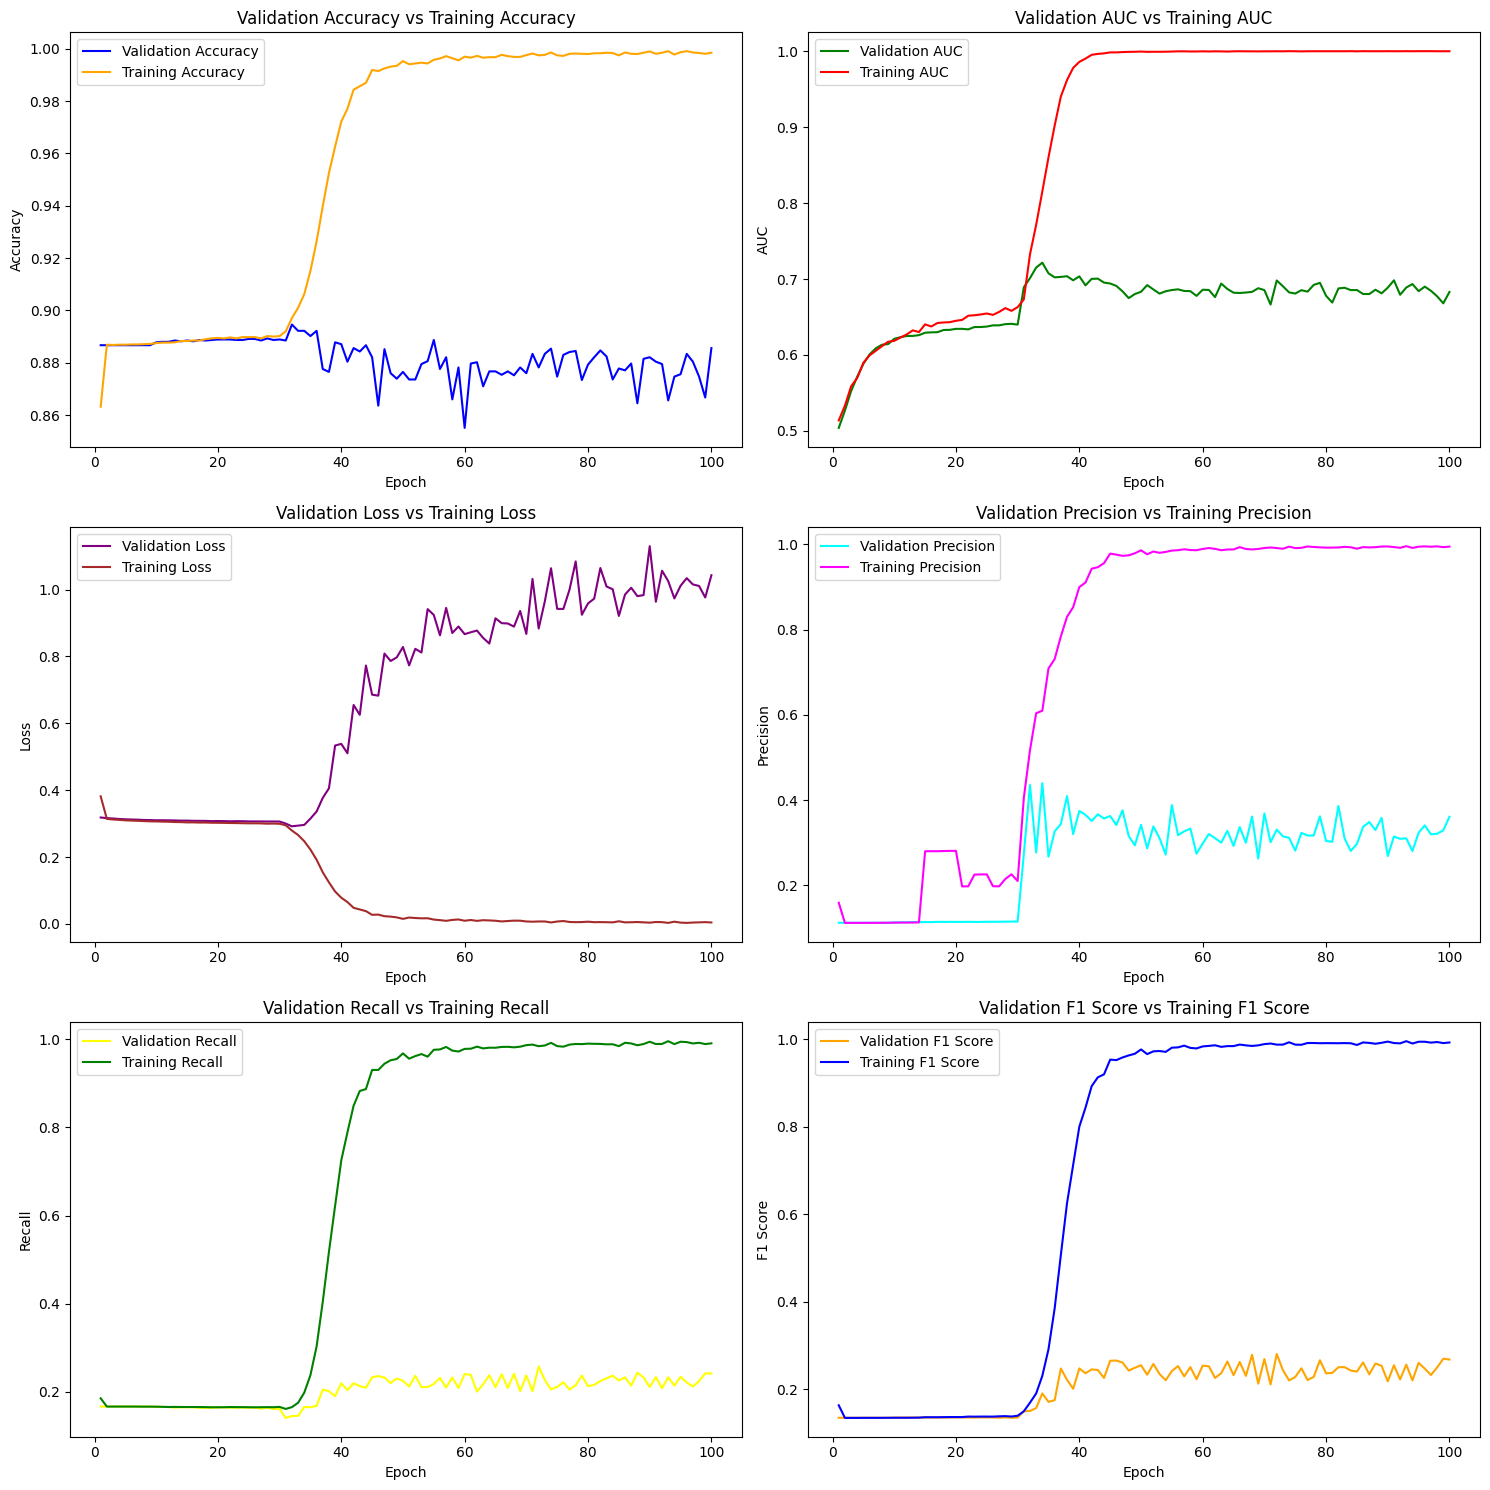

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
model_path = '/kaggle/working/best_model_precision.pth'
# model_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/best_model_auc.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()


        scores = torch.sigmoid(outputs)
        predictions = torch.sigmoid(outputs) > 0.5
        total_test += labels.size(0) * labels.size(1)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases)) 
    # adjust the target_names

    cm = multilabel_confusion_matrix(test_predictions_all, test_labels_all)
    # we will use macro-averaging strategy.
    accuracy_arr = []
    precision_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(num_classes):
        print(cm[i])
        print(cm[i].sum())

#         cfm_plot = sn.heatmap(cm[i], annot=False)
         # TP + TN / TP + TN  + FP + FN
        accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

        # TP / TP + FP
        precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

        # TP / TP + FN
        recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
        f1 = (2*precision*recall)/(precision+recall)
        print(disease_labels[i],": ",round(accuracy*100,2),"%") ### disease or disease_labels
        print("Precision: ",round(precision,2))
        print("Recall:", round(recall,2))
        print("F1-Score:", round(f1,2))
        print('==========================================================')


        accuracy_arr.append(accuracy)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)
    
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
            
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
    
    accuracy_macro_test = round(sum(accuracy_arr) / len(accuracy_arr), 4)
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)
    roc_auc_macro_test = round(roc_auc_score(test_labels_all, test_scores_all, average='macro'), 4)

    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 174/174 [00:20<00:00,  8.37it/s]

Accuracy: 0.8915
correct: 7414  out of  8316
                  precision    recall  f1-score   support

      No finding       0.76      0.84      0.80       907
      Bronchitis       0.64      0.04      0.08       174
Brocho-pneumonia       0.50      0.05      0.09        84
   Other disease       0.50      0.01      0.03        77
   Bronchiolitis       0.22      0.02      0.04        90
       Pneumonia       0.46      0.07      0.12        89

       micro avg       0.75      0.55      0.63      1421
       macro avg       0.51      0.17      0.19      1421
    weighted avg       0.66      0.55      0.53      1421
     samples avg       0.56      0.56      0.56      1421

[[242 148]
 [237 759]]
1386
No finding :  72.22 %
Precision:  0.76
Recall: 0.84
F1-Score: 0.8
[[1208  167]
 [   4    7]]
1386
Bronchitis :  87.66 %
Precision:  0.64
Recall: 0.04
F1-Score: 0.08
[[1298   80]
 [   4    4]]
1386
Brocho-pneumonia :  93.94 %
Precision:  0.5
Recall: 0.05
F1-Score: 0.09
[[1308   76]
 [  